# NY taxi fare prediction 

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Open the file

The `train.csv` file is very large (5GB).    
We can use the option `nrows` to limit the number of rows to explore the data.

In [4]:
filename = '../../../kaggle/NY_taxi_fare/new-york-city-taxi-fare-prediction/train.csv'
df = pd.read_csv(filename,
                 nrows=10000)

## Explore the dataset

In [5]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,11.235464,-72.466660,39.920448,-72.474094,39.893281,1.644700
std,9.584258,10.609729,7.318932,10.579732,6.339919,1.271229
min,-2.900000,-74.438233,-74.006893,-74.429332,-73.994392,0.000000
25%,6.000000,-73.992058,40.734547,-73.991112,40.735230,1.000000
50%,8.500000,-73.981758,40.752693,-73.980083,40.753738,1.000000
75%,12.500000,-73.966925,40.767694,-73.963504,40.768186,2.000000
max,180.000000,40.766125,401.083332,40.802437,41.366138,6.000000


In [6]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

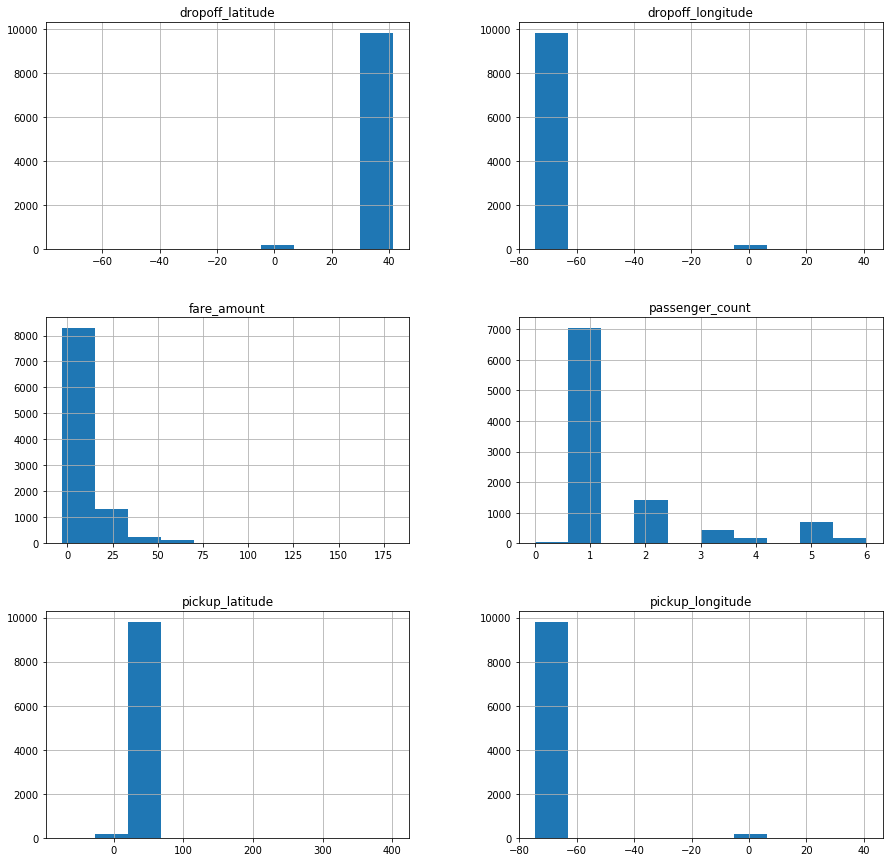

In [7]:
df.hist(figsize=(15,15));

## Filter the data

We can see that some values are weird or unexpected.   
For example: 
- pickup or dropoff latitude/longitude = 0
- very large latitude/longitude (NY latitude=40, longitude=-73)
- `passenger_count = 0`

We can filter these values, for example creating a new dataset

In [8]:
latitude_min = 20
latitude_max = 50
longitude_min = -85
longitude_max = -60

filter = (df.passenger_count > 0) \
& (df.pickup_latitude > latitude_min) & (df.pickup_latitude < latitude_max) \
& (df.dropoff_latitude > latitude_min) & (df.dropoff_latitude < latitude_max) \
& (df.pickup_longitude > longitude_min) & (df.pickup_longitude < longitude_max) \
& (df.dropoff_longitude > longitude_min) & (df.dropoff_longitude < longitude_max)

filtered_df = df[filter]

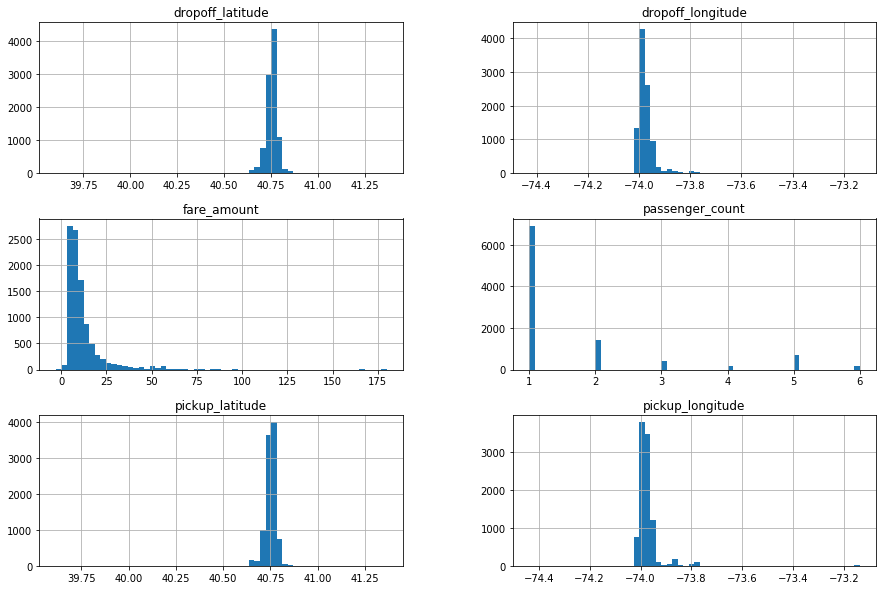

In [9]:
filtered_df.hist(figsize=(15,10), bins=60);

## Compute the distance of each taxi

### Euclidian distance

In [10]:
euclidian_distance = np.sqrt((filtered_df.dropoff_latitude - 
                              filtered_df.pickup_latitude)**2 
                             + (filtered_df.dropoff_longitude -
                                filtered_df.pickup_longitude)**2)


In [11]:
filtered_df = filtered_df.assign(euclidian_distance= euclidian_distance)

In [12]:
filtered_df.euclidian_distance.describe()

count    9755.000000
mean        0.034748
std         0.046881
min         0.000000
25%         0.012707
50%         0.021886
75%         0.039074
max         1.071539
Name: euclidian_distance, dtype: float64

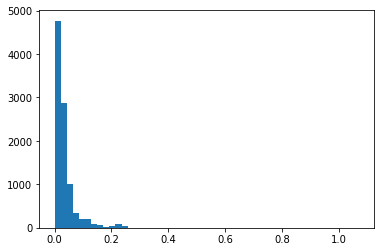

In [13]:
plt.hist(filtered_df.euclidian_distance, bins=50);

### Haversine distance

The exact distance between two points on Earth can be computed through the Harvesine formula.
https://en.wikipedia.org/wiki/Haversine_formula

In [15]:
def harvesine(latitude_start, longitude_start, latitude_end, longitude_end):
    """ Compute the distance between two points on Earth surface 
    Points are given with latitude and longitude in degrees
    Distance is returned in km
    """
    lat1 = np.deg2rad(latitude_start)
    long1 = np.deg2rad(longitude_start)
    lat2 = np.deg2rad(latitude_end)
    long2 = np.deg2rad(longitude_end)
    
    dlat = lat2 - lat1
    dlong = long2 - long1
    a = np.sin(dlat/2.)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2)**2
    # c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    c = 2 * np.arcsin(np.sqrt(a))
    R_earth = 6371
    return R_earth * c

In [16]:
harvesine_distance = harvesine(filtered_df.pickup_latitude,
                               filtered_df.pickup_longitude,
                               filtered_df.dropoff_latitude,
                               filtered_df.dropoff_longitude
                              )

In [17]:
filtered_df = filtered_df.assign(harvesine = harvesine_distance)

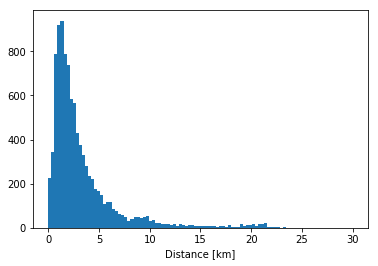

In [18]:
plt.hist(filtered_df.harvesine, bins=100, range=(0, 30));
plt.xlabel("Distance [km]");

## Map it

We can see the pick-up location on a map

In [76]:
nyc_map = plt.imread('nyc_-75_40_-73_41.5.png')

(40, 41.5)

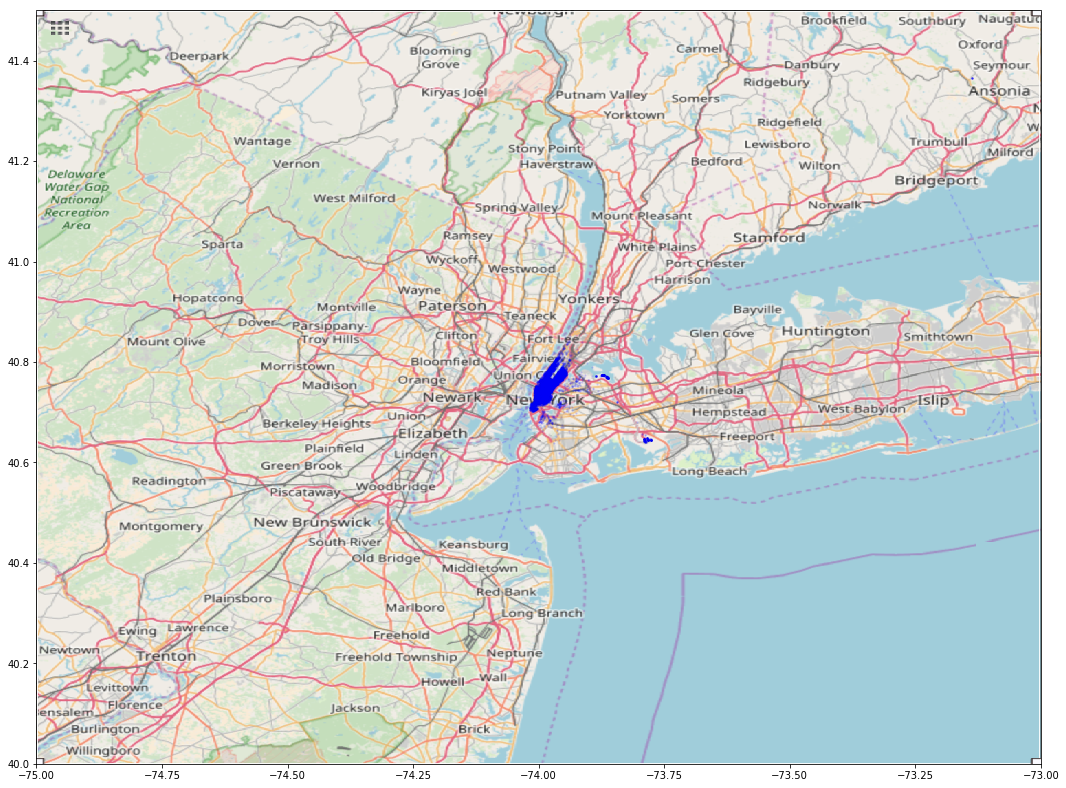

In [86]:
fig, ax = plt.subplots(figsize=(18,18))

box = [-75, -73, 40, 41.5]

plt.imshow(nyc_map, zorder=0, extent=box);

plt.scatter(filtered_df.pickup_longitude, 
           filtered_df.pickup_latitude,
            s=2,
            alpha=0.1,
            color='blue'
          );
plt.xlim(box[0], box[1])
plt.ylim(box[2], box[3])

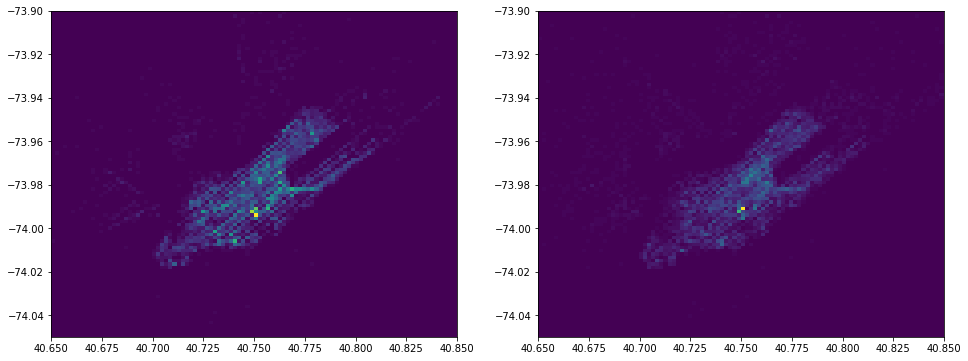

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

axes[0].hist2d(filtered_df.pickup_latitude, 
               filtered_df.pickup_longitude,
               bins=100,
               range=((40.65, 40.85), (-74.05, -73.9))
          );

axes[1].hist2d(filtered_df.dropoff_latitude, 
           filtered_df.dropoff_longitude,
           bins=100,
            range=((40.65, 40.85), (-74.05, -73.9)),
          );


The `pickup_datetime` feature does not appear in the plot because it's not recognised as a number.
We'll need to parse it.

In [91]:
from datetime import datetime

#### todo: use the module datetime to parse `pickup_datetime`  and add the columns `year`, `month`, `day`, `hour`, `weekdays` to the dataframe

In [92]:
def get_time_dataset(dataset):
    year = []
    month = []
    day = []
    hour = []
    minute = []
    weekday = []
    week = []

    for k in dataset.pickup_datetime:
        date = datetime.strptime(k[:-4], '%Y-%m-%d %H:%M:%S')
        year.append(date.year)
        month.append(date.month)
        day.append(date.day)
        hour.append(date.hour)
        minute.append(date.minute)
        weekday.append(date.weekday())
        week.append(date.isocalendar()[1])

    dataset['year'] = year
    dataset['month'] = month
    dataset['day'] = day
    dataset['hour'] = hour
    dataset['minute'] = minute
    dataset['weekday'] = weekday
    dataset['week'] = week

In [93]:
get_time_dataset(filtered_df)

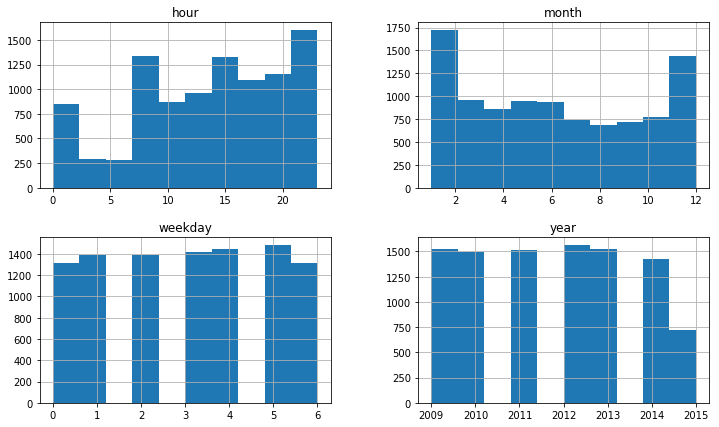

In [98]:
filtered_df[['year', 'month', 'hour', 'weekday']].hist(figsize=(12,7));

## Corelations

Let's see if there are some obvious correlation

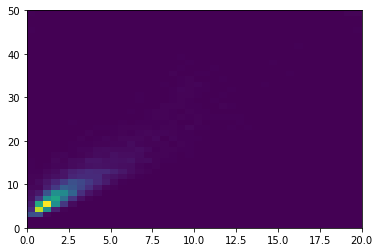

In [137]:
plt.hist2d(filtered_df.harvesine, 
           filtered_df.fare_amount, 
           bins=40,
           range = ((0, 20), (0, 50))
          );

## Machine learning

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### STEPS:
1. scale the values
- split train/test 
- train different models (e.g. `LinearRegression` and `RandomForestRegressor`)
- see which one works best
- improve performance of the model with
    - more data
    - hyperparameters tunning (gridsearch)

In [103]:
# Choose the features
training_features = ['harvesine', 
                     'passenger_count',
                     'pickup_latitude',
                     'pickup_longitude',
                     'dropoff_latitude',
                     'dropoff_longitude',
                     'weekday',
                     'hour',
                     'month',
                     'year',
                    ]
predict_features = ['fare_amount']
all_features = training_features + predict_features

In [104]:
input_scaler = StandardScaler()
output_scaler = StandardScaler()

input_scaler.fit(filtered_df[training_features])
output_scaler.fit(filtered_df[predict_features])

/Users/thomasvuillaume/anaconda/envs/MLS/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [105]:
scaled_input = input_scaler.transform(filtered_df[training_features])
scaled_ouput = output_scaler.transform(filtered_df[predict_features])


/Users/thomasvuillaume/anaconda/envs/MLS/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [106]:
scaled_input.shape, scaled_ouput.shape

((9755, 10), (9755, 1))

In [107]:
train_input, test_input, train_output, test_output = \
train_test_split(scaled_input, scaled_ouput,
                 test_size=0.2,
                 random_state=42,
                )

In [108]:
train_input.shape, test_input.shape, \
train_output.shape, test_output.shape

((7804, 10), (1951, 10), (7804, 1), (1951, 1))

In [111]:
# model = LinearRegression()
model = RandomForestRegressor()
model.fit(train_input, train_output)

/Users/thomasvuillaume/anaconda/envs/MLS/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/thomasvuillaume/anaconda/envs/MLS/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Let's see how the prediction compares to the real values:

In [119]:
test_predidction = model.predict(test_input)

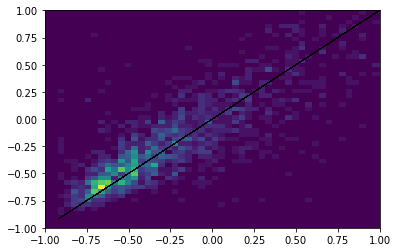

In [120]:
plt.hist2d(test_output[:,0], 
           test_predidction,
           bins=50,
           range=((-1,1), (-1,1))
          );
plt.plot(test_output[:,0], test_output[:,0], color='black', lw=0.3)

Ways to improve this:
- try other models
- fine tune the hyperparameters of the model
- ingest more training data
- compute new features (e.g. distance by car instead of straight distance)